In [12]:
import pandas as pd

In [13]:
df = pd.read_csv('../../datasets/oil.csv')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       1218 non-null   object 
 1   oil_price  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [15]:
df

,date,oil_price
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


<Axes: xlabel='date'>

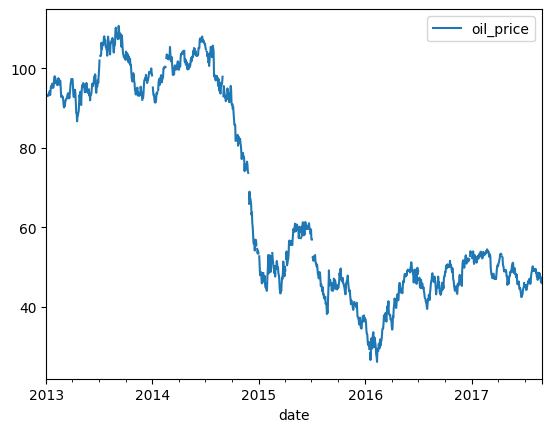

In [16]:
df.index = pd.to_datetime(df['date'])
df.plot()

In [17]:
price = df['oil_price']
price.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1218 entries, 2013-01-01 to 2017-08-31
Series name: oil_price
Non-Null Count  Dtype  
--------------  -----  
1175 non-null   float64
dtypes: float64(1)
memory usage: 19.0 KB


<Axes: xlabel='date'>

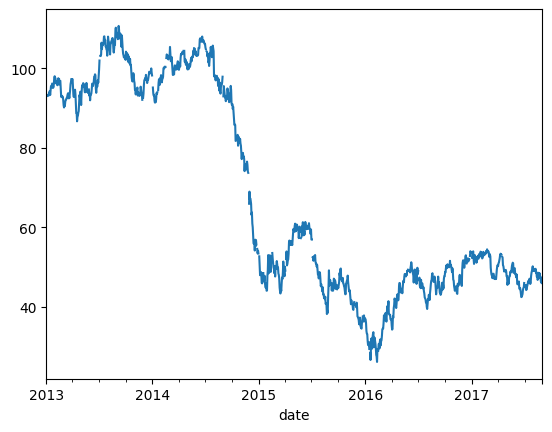

In [18]:
price.plot()

<Axes: xlabel='date'>

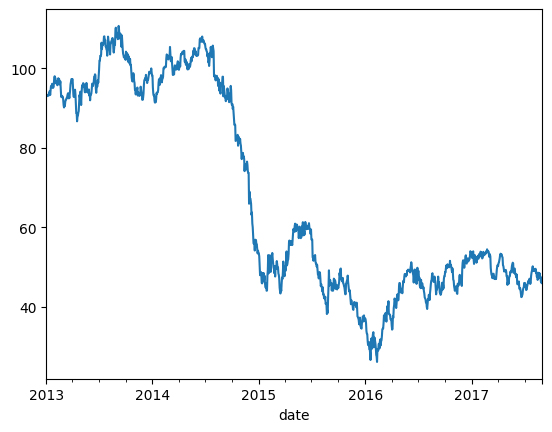

In [19]:
price_ffill = price.ffill()

price_ffill.plot()

<Axes: xlabel='date'>

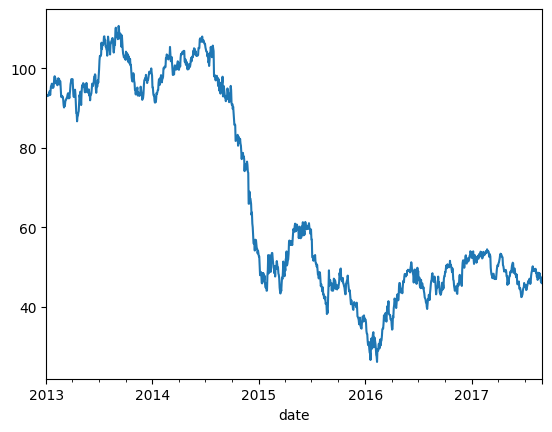

In [20]:
price_bfill = price.bfill()

price_bfill.plot()

In [21]:
price_int = price.interpolate()
price_int.bfill(inplace=True)

price_int.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1218 entries, 2013-01-01 to 2017-08-31
Series name: oil_price
Non-Null Count  Dtype  
--------------  -----  
1218 non-null   float64
dtypes: float64(1)
memory usage: 19.0 KB


In [22]:
price_treated = price.interpolate()


In [23]:
import tensorflow as tf
import numpy as np

2025-02-07 18:17:34.613833: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-07 18:17:34.625590: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-07 18:17:34.652340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738963054.692795   46553 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738963054.705914   46553 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-07 18:17:34.758191: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [24]:
### Formato da matriz
#### ----------------------------
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [25]:
## Especificando o tamanho da janela de observação
WINDOW_SIZE = 5
X, y = df_to_X_y(price_int, WINDOW_SIZE)
X.shape, y.shape

((1213, 5, 1), (1213,))

In [26]:
## Dividindo o dataset em treinamento, validação e teste

### Treinamento até 60.000 (instâncias)
X_train, y_train = X[:900], y[:900]

### Validação a partir de 60.000 até 65.000
X_val, y_val = X[900:1050], y[900:1050]

## Teste a partir de 65.000
X_test, y_test = X[1050:], y[1050:]

### Imprimindo o formato
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((900, 5, 1), (900,), (150, 5, 1), (150,), (163, 5, 1), (163,))

In [27]:
### Imports do TensorFlow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

modelo = Sequential()

## O primeiro número (5) representa o número de time steps (sequência de 5 valores anteriores)
## O segundo número (1) é o número de features (T (degC)).
modelo.add(InputLayer((5, 1)))

## camada LSTM com 64 unidades (neurônios).
modelo.add(LSTM(64))

## Adiciona uma camada densa (fully connected) com 8 neurônios.
modelo.add(Dense(8, 'relu'))

## Essa é a camada final do modelo.
## Ela tem um único neurônio de saída e uma função de ativação linear.
## Isso é ideal para problemas de regressão, como previsão de séries temporais.
modelo.add(Dense(1, 'linear'))

## Exibe a estrutura do modelo, mostrando o número de parâmetros treináveis em cada camada.
modelo.summary()


2025-02-07 18:17:47.537977: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
## Criando um Checkpoint. Salva o modelo durante o treinamento.
cp = ModelCheckpoint('modelo1.h5', save_best_only=True)

## Compilando o Modelo
modelo.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001),
               metrics=[RootMeanSquaredError()])

In [29]:
## Treinando o modelo
modelo.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, callbacks=[cp])

Epoch 1/300
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6488.5825 - root_mean_squared_error: 80.5499

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 6469.1621 - root_mean_squared_error: 80.4292 - val_loss: 2333.9631 - val_root_mean_squared_error: 48.3111
Epoch 2/300
23/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6470.1890 - root_mean_squared_error: 80.4151

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6433.4316 - root_mean_squared_error: 80.1905 - val_loss: 2285.4695 - val_root_mean_squared_error: 47.8066
Epoch 3/300
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6514.6636 - root_mean_squared_error: 80.6940

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6464.9897 - root_mean_squared_error: 80.3871 - val_loss: 2246.4026 - val_root_mean_squared_error: 47.3962
Epoch 4/300
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6110.3970 - root_mean_squared_error: 78.1654

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6123.6279 - root_mean_squared_error: 78.2503 - val_loss: 2222.0820 - val_root_mean_squared_error: 47.1390
Epoch 5/300
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6048.3608 - root_mean_squared_error: 77.7689

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6071.4224 - root_mean_squared_error: 77.9169 - val_loss: 2198.8413 - val_root_mean_squared_error: 46.8918
Epoch 6/300
23/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6337.9077 - root_mean_squared_error: 79.5942

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6283.3447 - root_mean_squared_error: 79.2522 - val_loss: 2174.5859 - val_root_mean_squared_error: 46.6325
Epoch 7/300
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6136.4287 - root_mean_squared_error: 78.3264

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6130.6060 - root_mean_squared_error: 78.2901 - val_loss: 2146.5007 - val_root_mean_squared_error: 46.3303
Epoch 8/300
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6194.1895 - root_mean_squared_error: 78.6972

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6168.1362 - root_mean_squared_error: 78.5316 - val_loss: 2114.1572 - val_root_mean_squared_error: 45.9800
Epoch 9/300
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6016.6396 - root_mean_squared_error: 77.5632

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6011.4814 - root_mean_squared_error: 77.5305 - val_loss: 2073.4651 - val_root_mean_squared_error: 45.5353
Epoch 10/300
23/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5962.4419 - root_mean_squared_error: 77.2020

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5956.2085 - root_mean_squared_error: 77.1650 - val_loss: 2024.8051 - val_root_mean_squared_error: 44.9978
Epoch 11/300
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5780.1968 - root_mean_squared_error: 76.0090

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5794.8291 - root_mean_squared_error: 76.1080 - val_loss: 1966.7729 - val_root_mean_squared_error: 44.3483
Epoch 12/300
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5834.2632 - root_mean_squared_error: 76.3783

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5826.1987 - root_mean_squared_error: 76.3261 - val_loss: 1905.7113 - val_root_mean_squared_error: 43.6545
Epoch 13/300
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5662.2051 - root_mean_squared_error: 75.2263

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5665.1348 - root_mean_squared_error: 75.2478 - val_loss: 1842.8158 - val_root_mean_squared_error: 42.9280
Epoch 14/300
20/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5638.5146 - root_mean_squared_error: 75.0663

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5619.5791 - root_mean_squared_error: 74.9478 - val_loss: 1781.7117 - val_root_mean_squared_error: 42.2103
Epoch 15/300
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5336.1680 - root_mean_squared_error: 73.0382

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5367.4565 - root_mean_squared_error: 73.2529 - val_loss: 1714.4087 - val_root_mean_squared_error: 41.4054
Epoch 16/300
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5443.7339 - root_mean_squared_error: 73.7750

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5439.5244 - root_mean_squared_error: 73.7469 - val_loss: 1636.9640 - val_root_mean_squared_error: 40.4594
Epoch 17/300
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5330.0420 - root_mean_squared_error: 73.0058

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5320.9424 - root_mean_squared_error: 72.9435 - val_loss: 1563.5327 - val_root_mean_squared_error: 39.5415
Epoch 18/300
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5228.3877 - root_mean_squared_error: 72.2969

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5210.4287 - root_mean_squared_error: 72.1739 - val_loss: 1496.5681 - val_root_mean_squared_error: 38.6855
Epoch 19/300
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4966.1987 - root_mean_squared_error: 70.4651

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4967.5488 - root_mean_squared_error: 70.4756 - val_loss: 1429.4432 - val_root_mean_squared_error: 37.8080
Epoch 20/300
21/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4852.5718 - root_mean_squared_error: 69.6400

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4868.9805 - root_mean_squared_error: 69.7634 - val_loss: 1359.8264 - val_root_mean_squared_error: 36.8758
Epoch 21/300
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4921.4204 - root_mean_squared_error: 70.1419

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4905.0415 - root_mean_squared_error: 70.0252 - val_loss: 1293.8135 - val_root_mean_squared_error: 35.9696
Epoch 22/300
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4632.3428 - root_mean_squared_error: 68.0501

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4633.2280 - root_mean_squared_error: 68.0574 - val_loss: 1232.1466 - val_root_mean_squared_error: 35.1019
Epoch 23/300
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4595.6509 - root_mean_squared_error: 67.7836

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4590.8862 - root_mean_squared_error: 67.7491 - val_loss: 1175.7362 - val_root_mean_squared_error: 34.2890
Epoch 24/300
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4615.4731 - root_mean_squared_error: 67.9307

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4585.5210 - root_mean_squared_error: 67.7097 - val_loss: 1126.8539 - val_root_mean_squared_error: 33.5686
Epoch 25/300
21/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4372.5747 - root_mean_squared_error: 66.1220

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4369.7783 - root_mean_squared_error: 66.1019 - val_loss: 1083.1379 - val_root_mean_squared_error: 32.9111
Epoch 26/300
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4420.1025 - root_mean_squared_error: 66.4763

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4403.8340 - root_mean_squared_error: 66.3535 - val_loss: 1040.0667 - val_root_mean_squared_error: 32.2501
Epoch 27/300
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4016.4265 - root_mean_squared_error: 63.3570

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4030.5745 - root_mean_squared_error: 63.4694 - val_loss: 998.0912 - val_root_mean_squared_error: 31.5926
Epoch 28/300
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4052.1863 - root_mean_squared_error: 63.6517

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4053.6267 - root_mean_squared_error: 63.6633 - val_loss: 954.3342 - val_root_mean_squared_error: 30.8923
Epoch 29/300
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4065.5974 - root_mean_squared_error: 63.7591

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4059.0549 - root_mean_squared_error: 63.7078 - val_loss: 907.6253 - val_root_mean_squared_error: 30.1268
Epoch 30/300
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3981.9253 - root_mean_squared_error: 63.0971

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3978.0552 - root_mean_squared_error: 63.0667 - val_loss: 863.7137 - val_root_mean_squared_error: 29.3890
Epoch 31/300
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3722.3257 - root_mean_squared_error: 60.9847

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3730.1641 - root_mean_squared_error: 61.0502 - val_loss: 824.1281 - val_root_mean_squared_error: 28.7076
Epoch 32/300
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3685.2607 - root_mean_squared_error: 60.6966

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3692.7610 - root_mean_squared_error: 60.7591 - val_loss: 785.2311 - val_root_mean_squared_error: 28.0220
Epoch 33/300
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3731.3486 - root_mean_squared_error: 61.0826

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3727.8862 - root_mean_squared_error: 61.0543 - val_loss: 740.9716 - val_root_mean_squared_error: 27.2208
Epoch 34/300
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3658.8560 - root_mean_squared_error: 60.4757

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3654.8010 - root_mean_squared_error: 60.4429 - val_loss: 702.3673 - val_root_mean_squared_error: 26.5022
Epoch 35/300
23/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3434.4429 - root_mean_squared_error: 58.6008

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3454.9607 - root_mean_squared_error: 58.7755 - val_loss: 670.1973 - val_root_mean_squared_error: 25.8882
Epoch 36/300
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3428.4854 - root_mean_squared_error: 58.5412

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3429.3279 - root_mean_squared_error: 58.5500 - val_loss: 640.4537 - val_root_mean_squared_error: 25.3072
Epoch 37/300
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3303.9087 - root_mean_squared_error: 57.4750

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3310.2593 - root_mean_squared_error: 57.5305 - val_loss: 612.2872 - val_root_mean_squared_error: 24.7444
Epoch 38/300
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3273.6643 - root_mean_squared_error: 57.2087

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3278.0383 - root_mean_squared_error: 57.2480 - val_loss: 585.0606 - val_root_mean_squared_error: 24.1880
Epoch 39/300
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3211.0469 - root_mean_squared_error: 56.6528

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3216.8948 - root_mean_squared_error: 56.7060 - val_loss: 558.9636 - val_root_mean_squared_error: 23.6424
Epoch 40/300
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3393.3982 - root_mean_squared_error: 58.2428

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3358.6375 - root_mean_squared_error: 57.9425 - val_loss: 532.8162 - val_root_mean_squared_error: 23.0828
Epoch 41/300
22/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3344.5535 - root_mean_squared_error: 57.8138

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3298.0298 - root_mean_squared_error: 57.4110 - val_loss: 503.6890 - val_root_mean_squared_error: 22.4430
Epoch 42/300
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3171.0669 - root_mean_squared_error: 56.2995

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3156.9377 - root_mean_squared_error: 56.1758 - val_loss: 471.8302 - val_root_mean_squared_error: 21.7217
Epoch 43/300
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2991.2708 - root_mean_squared_error: 54.6877

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2995.4204 - root_mean_squared_error: 54.7260 - val_loss: 443.9810 - val_root_mean_squared_error: 21.0709
Epoch 44/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2997.2810 - root_mean_squared_error: 54.7429

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2996.1033 - root_mean_squared_error: 54.7323 - val_loss: 419.2117 - val_root_mean_squared_error: 20.4747
Epoch 45/300
22/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2981.0012 - root_mean_squared_error: 54.5929

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2960.5413 - root_mean_squared_error: 54.4058 - val_loss: 395.8581 - val_root_mean_squared_error: 19.8962
Epoch 46/300
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2865.9822 - root_mean_squared_error: 53.5332

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2862.1003 - root_mean_squared_error: 53.4972 - val_loss: 373.6094 - val_root_mean_squared_error: 19.3290
Epoch 47/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2834.6597 - root_mean_squared_error: 53.2323 

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2832.9712 - root_mean_squared_error: 53.2167 - val_loss: 349.3790 - val_root_mean_squared_error: 18.6917
Epoch 48/300
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2788.5437 - root_mean_squared_error: 52.7975 

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2782.9871 - root_mean_squared_error: 52.7455 - val_loss: 324.4006 - val_root_mean_squared_error: 18.0111
Epoch 49/300
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2782.9155 - root_mean_squared_error: 52.7465

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2763.8525 - root_mean_squared_error: 52.5656 - val_loss: 303.1551 - val_root_mean_squared_error: 17.4114
Epoch 50/300
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2561.7456 - root_mean_squared_error: 50.5842

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2569.4424 - root_mean_squared_error: 50.6637 - val_loss: 283.8839 - val_root_mean_squared_error: 16.8489
Epoch 51/300
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2544.3765 - root_mean_squared_error: 50.4374

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2546.3479 - root_mean_squared_error: 50.4574 - val_loss: 265.2105 - val_root_mean_squared_error: 16.2853
Epoch 52/300
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2473.6030 - root_mean_squared_error: 49.7286

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2476.0239 - root_mean_squared_error: 49.7533 - val_loss: 247.6824 - val_root_mean_squared_error: 15.7379
Epoch 53/300
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2425.1045 - root_mean_squared_error: 49.2194

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2427.5850 - root_mean_squared_error: 49.2463 - val_loss: 230.7959 - val_root_mean_squared_error: 15.1920
Epoch 54/300
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2588.4250 - root_mean_squared_error: 50.8689

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2556.8628 - root_mean_squared_error: 50.5553 - val_loss: 214.4203 - val_root_mean_squared_error: 14.6431
Epoch 55/300
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2512.2644 - root_mean_squared_error: 50.1100

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2489.5142 - root_mean_squared_error: 49.8820 - val_loss: 199.2343 - val_root_mean_squared_error: 14.1150
Epoch 56/300
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2411.5234 - root_mean_squared_error: 49.0911 

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2394.3193 - root_mean_squared_error: 48.9176 - val_loss: 184.8216 - val_root_mean_squared_error: 13.5949
Epoch 57/300
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2440.6162 - root_mean_squared_error: 49.3869

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2411.1694 - root_mean_squared_error: 49.0874 - val_loss: 170.7147 - val_root_mean_squared_error: 13.0658
Epoch 58/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2279.3259 - root_mean_squared_error: 47.7412 

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2278.0017 - root_mean_squared_error: 47.7273 - val_loss: 157.4602 - val_root_mean_squared_error: 12.5483
Epoch 59/300
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2149.9124 - root_mean_squared_error: 46.3491

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2156.4707 - root_mean_squared_error: 46.4218 - val_loss: 144.8275 - val_root_mean_squared_error: 12.0344
Epoch 60/300
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2099.6897 - root_mean_squared_error: 45.8181

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2108.5066 - root_mean_squared_error: 45.9144 - val_loss: 132.6569 - val_root_mean_squared_error: 11.5177
Epoch 61/300
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2158.6797 - root_mean_squared_error: 46.4553

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2151.0835 - root_mean_squared_error: 46.3745 - val_loss: 121.1621 - val_root_mean_squared_error: 11.0074
Epoch 62/300
22/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2068.8606 - root_mean_squared_error: 45.4628

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2071.3704 - root_mean_squared_error: 45.4962 - val_loss: 110.3919 - val_root_mean_squared_error: 10.5068
Epoch 63/300
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2101.5994 - root_mean_squared_error: 45.8344

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2092.8567 - root_mean_squared_error: 45.7394 - val_loss: 100.1143 - val_root_mean_squared_error: 10.0057
Epoch 64/300
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1925.9536 - root_mean_squared_error: 43.8780

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1933.2552 - root_mean_squared_error: 43.9612 - val_loss: 90.4519 - val_root_mean_squared_error: 9.5106
Epoch 65/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1931.4384 - root_mean_squared_error: 43.9402

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1932.4150 - root_mean_squared_error: 43.9516 - val_loss: 81.3103 - val_root_mean_squared_error: 9.0172
Epoch 66/300
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1868.5232 - root_mean_squared_error: 43.2102

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1877.1178 - root_mean_squared_error: 43.3117 - val_loss: 72.8684 - val_root_mean_squared_error: 8.5363
Epoch 67/300
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1930.6206 - root_mean_squared_error: 43.9325 

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1922.5702 - root_mean_squared_error: 43.8417 - val_loss: 64.9641 - val_root_mean_squared_error: 8.0600
Epoch 68/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1831.6343 - root_mean_squared_error: 42.7853

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1832.2916 - root_mean_squared_error: 42.7934 - val_loss: 57.5868 - val_root_mean_squared_error: 7.5886
Epoch 69/300
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1846.9528 - root_mean_squared_error: 42.9705

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1842.8892 - root_mean_squared_error: 42.9238 - val_loss: 50.6609 - val_root_mean_squared_error: 7.1176
Epoch 70/300
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1786.6747 - root_mean_squared_error: 42.2571

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1786.4174 - root_mean_squared_error: 42.2553 - val_loss: 44.5138 - val_root_mean_squared_error: 6.6719
Epoch 71/300
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1721.5939 - root_mean_squared_error: 41.4622

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1724.3127 - root_mean_squared_error: 41.4988 - val_loss: 38.9798 - val_root_mean_squared_error: 6.2434
Epoch 72/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1719.5513 - root_mean_squared_error: 41.4667

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1719.3962 - root_mean_squared_error: 41.4649 - val_loss: 33.7712 - val_root_mean_squared_error: 5.8113
Epoch 73/300
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1705.9052 - root_mean_squared_error: 41.2999

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1702.8616 - root_mean_squared_error: 41.2633 - val_loss: 29.1598 - val_root_mean_squared_error: 5.4000
Epoch 74/300
23/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1641.4249 - root_mean_squared_error: 40.5028

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1641.5906 - root_mean_squared_error: 40.5075 - val_loss: 25.1766 - val_root_mean_squared_error: 5.0176
Epoch 75/300
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1651.6213 - root_mean_squared_error: 40.6307

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1648.2524 - root_mean_squared_error: 40.5900 - val_loss: 21.6669 - val_root_mean_squared_error: 4.6548
Epoch 76/300
23/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1643.4240 - root_mean_squared_error: 40.5317

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1631.5378 - root_mean_squared_error: 40.3857 - val_loss: 18.7140 - val_root_mean_squared_error: 4.3260
Epoch 77/300
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1564.6125 - root_mean_squared_error: 39.5524

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1563.8064 - root_mean_squared_error: 39.5425 - val_loss: 16.3224 - val_root_mean_squared_error: 4.0401
Epoch 78/300
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1569.9496 - root_mean_squared_error: 39.6143

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1565.4899 - root_mean_squared_error: 39.5584 - val_loss: 14.4888 - val_root_mean_squared_error: 3.8064
Epoch 79/300
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1494.9059 - root_mean_squared_error: 38.6475

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1495.0940 - root_mean_squared_error: 38.6510 - val_loss: 13.0723 - val_root_mean_squared_error: 3.6156
Epoch 80/300
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1409.9573 - root_mean_squared_error: 37.5471

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1420.4161 - root_mean_squared_error: 37.6855 - val_loss: 12.1744 - val_root_mean_squared_error: 3.4892
Epoch 81/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1473.4740 - root_mean_squared_error: 38.3653

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1472.3962 - root_mean_squared_error: 38.3518 - val_loss: 11.6707 - val_root_mean_squared_error: 3.4162
Epoch 82/300
23/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1403.4171 - root_mean_squared_error: 37.4534

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1405.4972 - root_mean_squared_error: 37.4831 - val_loss: 11.6120 - val_root_mean_squared_error: 3.4076
Epoch 83/300
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1427.9606 - root_mean_squared_error: 37.7868

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1419.5167 - root_mean_squared_error: 37.6746 - val_loss: 9.7673 - val_root_mean_squared_error: 3.1253
Epoch 84/300
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1348.2086 - root_mean_squared_error: 36.7143

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1349.3352 - root_mean_squared_error: 36.7301 - val_loss: 7.8921 - val_root_mean_squared_error: 2.8093
Epoch 85/300
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1379.2310 - root_mean_squared_error: 37.1294

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1368.6150 - root_mean_squared_error: 36.9868 - val_loss: 7.2217 - val_root_mean_squared_error: 2.6873
Epoch 86/300
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1325.1492 - root_mean_squared_error: 36.3899

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1319.5239 - root_mean_squared_error: 36.3147 - val_loss: 6.8637 - val_root_mean_squared_error: 2.6199
Epoch 87/300
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1300.0967 - root_mean_squared_error: 36.0470 

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1295.7848 - root_mean_squared_error: 35.9882 - val_loss: 5.2703 - val_root_mean_squared_error: 2.2957
Epoch 88/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1238.3477 - root_mean_squared_error: 35.1881

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1238.2917 - root_mean_squared_error: 35.1874 - val_loss: 4.5577 - val_root_mean_squared_error: 2.1349
Epoch 89/300
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1228.7260 - root_mean_squared_error: 35.0488

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1224.0841 - root_mean_squared_error: 34.9832 - val_loss: 3.5753 - val_root_mean_squared_error: 1.8908
Epoch 90/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1185.3213 - root_mean_squared_error: 34.4240

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1185.0720 - root_mean_squared_error: 34.4205 - val_loss: 2.5600 - val_root_mean_squared_error: 1.6000
Epoch 91/300
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1154.0634 - root_mean_squared_error: 33.9671

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1153.2749 - root_mean_squared_error: 33.9564 - val_loss: 2.3769 - val_root_mean_squared_error: 1.5417
Epoch 92/300
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1074.4717 - root_mean_squared_error: 32.7420

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1077.7819 - root_mean_squared_error: 32.7944 - val_loss: 2.0713 - val_root_mean_squared_error: 1.4392
Epoch 93/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1121.6482 - root_mean_squared_error: 33.4804

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1120.8479 - root_mean_squared_error: 33.4687 - val_loss: 1.9062 - val_root_mean_squared_error: 1.3806
Epoch 94/300
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1051.8804 - root_mean_squared_error: 32.4283

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1053.9255 - root_mean_squared_error: 32.4601 - val_loss: 1.7034 - val_root_mean_squared_error: 1.3051
Epoch 95/300
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 993.8176 - root_mean_squared_error: 31.5107

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1000.4863 - root_mean_squared_error: 31.6171 - val_loss: 1.6321 - val_root_mean_squared_error: 1.2775
Epoch 96/300
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1012.5181 - root_mean_squared_error: 31.8179

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1015.0340 - root_mean_squared_error: 31.8577 - val_loss: 1.5724 - val_root_mean_squared_error: 1.2539
Epoch 97/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 980.5886 - root_mean_squared_error: 31.3090 - val_loss: 1.6791 - val_root_mean_squared_error: 1.2958
Epoch 98/300
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 973.2838 - root_mean_squared_error: 31.1935

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 973.2177 - root_mean_squared_error: 31.1928 - val_loss: 1.5681 - val_root_mean_squared_error: 1.2523
Epoch 99/300
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 971.2671 - root_mean_squared_error: 31.1623

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 966.6573 - root_mean_squared_error: 31.0884 - val_loss: 1.5107 - val_root_mean_squared_error: 1.2291
Epoch 100/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 896.5653 - root_mean_squared_error: 29.9394

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 897.5125 - root_mean_squared_error: 29.9552 - val_loss: 1.5105 - val_root_mean_squared_error: 1.2290
Epoch 101/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 900.0227 - root_mean_squared_error: 29.9901 - val_loss: 1.6318 - val_root_mean_squared_error: 1.2774
Epoch 102/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 855.0790 - root_mean_squared_error: 29.2370 - val_loss: 1.6747 - val_root_mean_squared_error: 1.2941
Epoch 103/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 849.3104 - root_mean_squared_error: 29.1414 - val_loss: 1.6363 - val_root_mean_squared_error: 1.2792
Epoch 104/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 830.4116 - root_mean_squared_error: 28.8135 - val_loss: 1.6477 - val_root_mean_squared_error: 1.2836
Epoch 105/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 845.4617 - root_mean_squared_error: 29.0714 - val_loss: 1.6197 - val_root_mean_squared_error: 1.2727
Epoch 106/300
29/29 ━━━━━━━━━━━━━━━━

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 566.5016 - root_mean_squared_error: 23.7829 - val_loss: 1.4468 - val_root_mean_squared_error: 1.2028
Epoch 117/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 592.8405 - root_mean_squared_error: 24.3353 - val_loss: 1.4688 - val_root_mean_squared_error: 1.2119
Epoch 118/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 542.5898 - root_mean_squared_error: 23.2672 - val_loss: 1.5692 - val_root_mean_squared_error: 1.2527
Epoch 119/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 535.4412 - root_mean_squared_error: 23.1363 - val_loss: 1.5645 - val_root_mean_squared_error: 1.2508
Epoch 120/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 554.6465 - root_mean_squared_error: 23.5424 - val_loss: 1.5690 - val_root_mean_squared_error: 1.2526
Epoch 121/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 495.7957 - root_mean_squared_error: 22.2495 - val_loss: 1.4516 - val_root_mean_squared_error: 1.2048
Epoch 122/300
29/29 ━━━━━━━━━━━━━━━━━

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 427.9162 - root_mean_squared_error: 20.6847 - val_loss: 1.4313 - val_root_mean_squared_error: 1.1964
Epoch 127/300
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 431.0211 - root_mean_squared_error: 20.7563

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 428.7770 - root_mean_squared_error: 20.7023 - val_loss: 1.4148 - val_root_mean_squared_error: 1.1895
Epoch 128/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 415.7052 - root_mean_squared_error: 20.3876 - val_loss: 1.5432 - val_root_mean_squared_error: 1.2423
Epoch 129/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 369.4005 - root_mean_squared_error: 19.2079 - val_loss: 1.4163 - val_root_mean_squared_error: 1.1901
Epoch 130/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 372.7974 - root_mean_squared_error: 19.3056 - val_loss: 1.4521 - val_root_mean_squared_error: 1.2050
Epoch 131/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 349.8994 - root_mean_squared_error: 18.7046 - val_loss: 1.4588 - val_root_mean_squared_error: 1.2078
Epoch 132/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 346.9090 - root_mean_squared_error: 18.6128 - val_loss: 1.4671 - val_root_mean_squared_error: 1.2112
Epoch 133/300
29/29 ━━━━━━━━━━━━━━━━

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 318.5503 - root_mean_squared_error: 17.8373 - val_loss: 1.3952 - val_root_mean_squared_error: 1.1812
Epoch 136/300
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 310.1603 - root_mean_squared_error: 17.6043

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 309.3181 - root_mean_squared_error: 17.5806 - val_loss: 1.3857 - val_root_mean_squared_error: 1.1772
Epoch 137/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 281.6962 - root_mean_squared_error: 16.7817 - val_loss: 1.4449 - val_root_mean_squared_error: 1.2020
Epoch 138/300
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 266.7242 - root_mean_squared_error: 16.3274

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 267.5842 - root_mean_squared_error: 16.3539 - val_loss: 1.3253 - val_root_mean_squared_error: 1.1512
Epoch 139/300
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 254.4937 - root_mean_squared_error: 15.9483 

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 256.2115 - root_mean_squared_error: 16.0024 - val_loss: 1.3128 - val_root_mean_squared_error: 1.1458
Epoch 140/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 258.3046 - root_mean_squared_error: 16.0702 - val_loss: 1.3349 - val_root_mean_squared_error: 1.1554
Epoch 141/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 262.6721 - root_mean_squared_error: 16.1974 - val_loss: 1.3230 - val_root_mean_squared_error: 1.1502
Epoch 142/300
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 247.6671 - root_mean_squared_error: 15.7253

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 246.7856 - root_mean_squared_error: 15.6978 - val_loss: 1.3006 - val_root_mean_squared_error: 1.1404
Epoch 143/300
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 223.3933 - root_mean_squared_error: 14.9245

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 223.9847 - root_mean_squared_error: 14.9478 - val_loss: 1.2984 - val_root_mean_squared_error: 1.1395
Epoch 144/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 218.1556 - root_mean_squared_error: 14.7664 - val_loss: 1.3028 - val_root_mean_squared_error: 1.1414
Epoch 145/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 215.9583 - root_mean_squared_error: 14.6913 - val_loss: 1.3073 - val_root_mean_squared_error: 1.1434
Epoch 146/300
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 209.7529 - root_mean_squared_error: 14.4779

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 209.0004 - root_mean_squared_error: 14.4519 - val_loss: 1.2899 - val_root_mean_squared_error: 1.1357
Epoch 147/300
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 195.9503 - root_mean_squared_error: 13.9915

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 195.2122 - root_mean_squared_error: 13.9659 - val_loss: 1.2882 - val_root_mean_squared_error: 1.1350
Epoch 148/300
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 188.9053 - root_mean_squared_error: 13.7365

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 188.4541 - root_mean_squared_error: 13.7204 - val_loss: 1.2720 - val_root_mean_squared_error: 1.1278
Epoch 149/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 173.6221 - root_mean_squared_error: 13.1690 - val_loss: 1.2953 - val_root_mean_squared_error: 1.1381
Epoch 150/300
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 168.8891 - root_mean_squared_error: 12.9768

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 168.6859 - root_mean_squared_error: 12.9708 - val_loss: 1.2610 - val_root_mean_squared_error: 1.1229
Epoch 151/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 156.3290 - root_mean_squared_error: 12.5015 - val_loss: 1.3164 - val_root_mean_squared_error: 1.1474
Epoch 152/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 156.6457 - root_mean_squared_error: 12.5100 - val_loss: 1.2626 - val_root_mean_squared_error: 1.1236
Epoch 153/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 151.0125 - root_mean_squared_error: 12.2852

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 150.8366 - root_mean_squared_error: 12.2781 - val_loss: 1.2491 - val_root_mean_squared_error: 1.1177
Epoch 154/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 127.5677 - root_mean_squared_error: 11.2858 - val_loss: 1.2560 - val_root_mean_squared_error: 1.1207
Epoch 155/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 130.8331 - root_mean_squared_error: 11.4364 - val_loss: 1.2572 - val_root_mean_squared_error: 1.1212
Epoch 156/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 132.9086 - root_mean_squared_error: 11.5161 - val_loss: 1.2600 - val_root_mean_squared_error: 1.1225
Epoch 157/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 127.5360 - root_mean_squared_error: 11.2872 - val_loss: 1.2643 - val_root_mean_squared_error: 1.1244
Epoch 158/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 121.5506 - root_mean_squared_error: 11.0226 - val_loss: 1.2591 - val_root_mean_squared_error: 1.1221
Epoch 159/300
29/29 ━━━━━━━━━━━━━━━━

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 99.5437 - root_mean_squared_error: 9.9758 - val_loss: 1.2217 - val_root_mean_squared_error: 1.1053
Epoch 162/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 90.5052 - root_mean_squared_error: 9.5119 - val_loss: 1.2338 - val_root_mean_squared_error: 1.1108
Epoch 163/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 91.7887 - root_mean_squared_error: 9.5730 - val_loss: 1.2462 - val_root_mean_squared_error: 1.1164
Epoch 164/300
23/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 79.8066 - root_mean_squared_error: 8.9290

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 81.1067 - root_mean_squared_error: 9.0015 - val_loss: 1.2216 - val_root_mean_squared_error: 1.1053
Epoch 165/300
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 86.9890 - root_mean_squared_error: 9.3220

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 86.4891 - root_mean_squared_error: 9.2953 - val_loss: 1.2152 - val_root_mean_squared_error: 1.1024
Epoch 166/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 78.1298 - root_mean_squared_error: 8.8373 - val_loss: 1.2576 - val_root_mean_squared_error: 1.1214
Epoch 167/300
23/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 73.2751 - root_mean_squared_error: 8.5564

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 73.4956 - root_mean_squared_error: 8.5701 - val_loss: 1.2044 - val_root_mean_squared_error: 1.0975
Epoch 168/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 70.5576 - root_mean_squared_error: 8.3971 - val_loss: 1.2194 - val_root_mean_squared_error: 1.1043
Epoch 169/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 67.4888 - root_mean_squared_error: 8.2124 - val_loss: 1.2185 - val_root_mean_squared_error: 1.1039
Epoch 170/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 63.8440 - root_mean_squared_error: 7.9837 - val_loss: 1.2110 - val_root_mean_squared_error: 1.1005
Epoch 171/300
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 61.0614 - root_mean_squared_error: 7.8108

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 60.9708 - root_mean_squared_error: 7.8056 - val_loss: 1.1928 - val_root_mean_squared_error: 1.0922
Epoch 172/300
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 59.8800 - root_mean_squared_error: 7.7323

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 59.5684 - root_mean_squared_error: 7.7127 - val_loss: 1.1899 - val_root_mean_squared_error: 1.0908
Epoch 173/300
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 52.7310 - root_mean_squared_error: 7.2574

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 53.0391 - root_mean_squared_error: 7.2792 - val_loss: 1.1870 - val_root_mean_squared_error: 1.0895
Epoch 174/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 50.3943 - root_mean_squared_error: 7.0971 - val_loss: 1.2063 - val_root_mean_squared_error: 1.0983
Epoch 175/300
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 54.3447 - root_mean_squared_error: 7.3629

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 53.5540 - root_mean_squared_error: 7.3095 - val_loss: 1.1839 - val_root_mean_squared_error: 1.0881
Epoch 176/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 47.6311 - root_mean_squared_error: 6.9003 - val_loss: 1.2400 - val_root_mean_squared_error: 1.1136
Epoch 177/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 44.9440 - root_mean_squared_error: 6.7024 - val_loss: 1.2145 - val_root_mean_squared_error: 1.1020
Epoch 178/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 40.8192 - root_mean_squared_error: 6.3622 - val_loss: 1.1911 - val_root_mean_squared_error: 1.0914
Epoch 179/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 42.2701 - root_mean_squared_error: 6.4923 - val_loss: 1.1898 - val_root_mean_squared_error: 1.0908
Epoch 180/300
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 38.0051 - root_mean_squared_error: 6.1573

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 38.0496 - root_mean_squared_error: 6.1614 - val_loss: 1.1799 - val_root_mean_squared_error: 1.0863
Epoch 181/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 36.3313 - root_mean_squared_error: 6.0257

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 36.3491 - root_mean_squared_error: 6.0272 - val_loss: 1.1764 - val_root_mean_squared_error: 1.0846
Epoch 182/300
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 36.8293 - root_mean_squared_error: 6.0672

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 36.5471 - root_mean_squared_error: 6.0440 - val_loss: 1.1742 - val_root_mean_squared_error: 1.0836
Epoch 183/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 33.0830 - root_mean_squared_error: 5.7495 - val_loss: 1.3233 - val_root_mean_squared_error: 1.1503
Epoch 184/300
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 34.3105 - root_mean_squared_error: 5.8491

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 34.0881 - root_mean_squared_error: 5.8307 - val_loss: 1.1694 - val_root_mean_squared_error: 1.0814
Epoch 185/300
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 30.8779 - root_mean_squared_error: 5.5483

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 30.8494 - root_mean_squared_error: 5.5466 - val_loss: 1.1679 - val_root_mean_squared_error: 1.0807
Epoch 186/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 31.4259 - root_mean_squared_error: 5.6019 - val_loss: 1.2240 - val_root_mean_squared_error: 1.1063
Epoch 187/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 28.6904 - root_mean_squared_error: 5.3553 - val_loss: 1.1860 - val_root_mean_squared_error: 1.0891
Epoch 188/300
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 25.1797 - root_mean_squared_error: 5.0086

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 25.4004 - root_mean_squared_error: 5.0315 - val_loss: 1.1579 - val_root_mean_squared_error: 1.0760
Epoch 189/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 24.6933 - root_mean_squared_error: 4.9586 - val_loss: 1.1839 - val_root_mean_squared_error: 1.0881
Epoch 190/300
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 22.2325 - root_mean_squared_error: 4.7094

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 22.5346 - root_mean_squared_error: 4.7414 - val_loss: 1.1578 - val_root_mean_squared_error: 1.0760
Epoch 191/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 22.4805 - root_mean_squared_error: 4.7397 - val_loss: 1.1841 - val_root_mean_squared_error: 1.0882
Epoch 192/300
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 24.7262 - root_mean_squared_error: 4.9690

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 24.4341 - root_mean_squared_error: 4.9394 - val_loss: 1.1552 - val_root_mean_squared_error: 1.0748
Epoch 193/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 22.9995 - root_mean_squared_error: 4.7804 - val_loss: 1.1569 - val_root_mean_squared_error: 1.0756
Epoch 194/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 20.8325 - root_mean_squared_error: 4.5602 - val_loss: 1.1760 - val_root_mean_squared_error: 1.0844
Epoch 195/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 20.1606 - root_mean_squared_error: 4.4804 - val_loss: 1.1579 - val_root_mean_squared_error: 1.0761
Epoch 196/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 18.0557 - root_mean_squared_error: 4.2405 - val_loss: 1.1583 - val_root_mean_squared_error: 1.0762
Epoch 197/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 18.8006 - root_mean_squared_error: 4.3275 - val_loss: 1.1601 - val_root_mean_squared_error: 1.0771
Epoch 198/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 17.5116 - root_mean_squared_error: 4.1760 - val_loss: 1.1538 - val_root_mean_squared_error: 1.0741
Epoch 200/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 14.4874 - root_mean_squared_error: 3.7925 - val_loss: 1.1699 - val_root_mean_squared_error: 1.0816
Epoch 201/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.9765 - root_mean_squared_error: 4.1169 - val_loss: 1.1828 - val_root_mean_squared_error: 1.0876
Epoch 202/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 16.1343 - root_mean_squared_error: 4.0112 - val_loss: 1.1894 - val_root_mean_squared_error: 1.0906
Epoch 203/300
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 13.6189 - root_mean_squared_error: 3.6783

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 13.7471 - root_mean_squared_error: 3.6975 - val_loss: 1.1526 - val_root_mean_squared_error: 1.0736
Epoch 204/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 14.5042 - root_mean_squared_error: 3.7983 - val_loss: 1.1803 - val_root_mean_squared_error: 1.0864
Epoch 205/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 12.8312 - root_mean_squared_error: 3.5738 - val_loss: 1.1574 - val_root_mean_squared_error: 1.0758
Epoch 206/300
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13.1700 - root_mean_squared_error: 3.6282

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 13.1457 - root_mean_squared_error: 3.6249 - val_loss: 1.1505 - val_root_mean_squared_error: 1.0726
Epoch 207/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 12.5922 - root_mean_squared_error: 3.5465 - val_loss: 1.1689 - val_root_mean_squared_error: 1.0812
Epoch 208/300
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.2695 - root_mean_squared_error: 3.3464

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 11.3308 - root_mean_squared_error: 3.3565 - val_loss: 1.1492 - val_root_mean_squared_error: 1.0720
Epoch 209/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 11.1493 - root_mean_squared_error: 3.3355

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 11.1590 - root_mean_squared_error: 3.3371 - val_loss: 1.1489 - val_root_mean_squared_error: 1.0719
Epoch 210/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 12.2500 - root_mean_squared_error: 3.4927 - val_loss: 1.1504 - val_root_mean_squared_error: 1.0726
Epoch 211/300
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10.7008 - root_mean_squared_error: 3.2622

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 10.6779 - root_mean_squared_error: 3.2601 - val_loss: 1.1484 - val_root_mean_squared_error: 1.0717
Epoch 212/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 10.5867 - root_mean_squared_error: 3.2475 - val_loss: 1.2137 - val_root_mean_squared_error: 1.1017
Epoch 213/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.4933 - root_mean_squared_error: 3.0735 - val_loss: 1.1604 - val_root_mean_squared_error: 1.0772
Epoch 214/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.0809 - root_mean_squared_error: 3.0108 - val_loss: 1.1521 - val_root_mean_squared_error: 1.0734
Epoch 215/300
22/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10.0449 - root_mean_squared_error: 3.1588

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.8309 - root_mean_squared_error: 3.1272 - val_loss: 1.1465 - val_root_mean_squared_error: 1.0707
Epoch 216/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.2477 - root_mean_squared_error: 3.0386 - val_loss: 1.2836 - val_root_mean_squared_error: 1.1329
Epoch 217/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.1124 - root_mean_squared_error: 2.8472 - val_loss: 1.1483 - val_root_mean_squared_error: 1.0716
Epoch 218/300
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.4362 - root_mean_squared_error: 2.8993

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.3745 - root_mean_squared_error: 2.8896 - val_loss: 1.1443 - val_root_mean_squared_error: 1.0697
Epoch 219/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.6359 - root_mean_squared_error: 2.9358 - val_loss: 1.1471 - val_root_mean_squared_error: 1.0710
Epoch 220/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.9701 - root_mean_squared_error: 2.8223 - val_loss: 1.1463 - val_root_mean_squared_error: 1.0706
Epoch 221/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.6149 - root_mean_squared_error: 2.7574 - val_loss: 1.1652 - val_root_mean_squared_error: 1.0795
Epoch 222/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.7368 - root_mean_squared_error: 2.5921 - val_loss: 1.1450 - val_root_mean_squared_error: 1.0700
Epoch 223/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.4772 - root_mean_squared_error: 2.5432 - val_loss: 1.1618 - val_root_mean_squared_error: 1.0779
Epoch 224/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.0464 - root_mean_squared_error: 2.2457 - val_loss: 1.1439 - val_root_mean_squared_error: 1.0695
Epoch 236/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2555 - root_mean_squared_error: 2.2866 - val_loss: 1.1482 - val_root_mean_squared_error: 1.0716
Epoch 237/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.8046 - root_mean_squared_error: 2.1886 - val_loss: 1.1626 - val_root_mean_squared_error: 1.0782
Epoch 238/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.9408 - root_mean_squared_error: 2.2210 - val_loss: 1.1444 - val_root_mean_squared_error: 1.0698
Epoch 239/300
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5832 - root_mean_squared_error: 2.1399

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.5710 - root_mean_squared_error: 2.1372 - val_loss: 1.1438 - val_root_mean_squared_error: 1.0695
Epoch 240/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.3921 - root_mean_squared_error: 2.0950 - val_loss: 1.1503 - val_root_mean_squared_error: 1.0725
Epoch 241/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.7872 - root_mean_squared_error: 2.1851 - val_loss: 1.1627 - val_root_mean_squared_error: 1.0783
Epoch 242/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.8956 - root_mean_squared_error: 1.9724 - val_loss: 1.1655 - val_root_mean_squared_error: 1.0796
Epoch 243/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.0546 - root_mean_squared_error: 2.0114 - val_loss: 1.1453 - val_root_mean_squared_error: 1.0702
Epoch 244/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.5817 - root_mean_squared_error: 1.8911 - val_loss: 1.1626 - val_root_mean_squared_error: 1.0782
Epoch 245/300
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 

In [1]:
## Importanto o modelo salvo
from tensorflow.keras.models import load_model
modelo_lstm = load_model('oil_price_model.h5')

2025-02-07 18:22:18.777637: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-07 18:22:18.793815: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-07 18:22:18.826117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738963338.864484   61624 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738963338.877610   61624 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-07 18:22:18.906056: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'oil_price_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


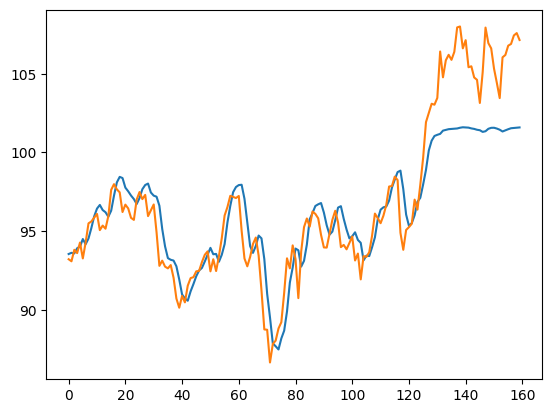

In [31]:
## Predições de treinamento
train_predictions = modelo_lstm.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Predições de treinamento:':train_predictions, 'Valores Reais:':y_train})

import matplotlib.pyplot as plt
plt.plot(train_results['Predições de treinamento:'][:160])
plt.plot(train_results['Valores Reais:'][:160])